# Machine learning on semantic type and category information for identifying drug-disease indications

#### *Wytze Vlietstra*

#### *19/06/2018*

-   [<span class="toc-section-number">1</span>
    Introduction](#introduction)
-   [<span class="toc-section-number">2</span> Methods &
    Results](#methods-results)
    -   [<span class="toc-section-number">2.1</span> Load the required
        packages](#load-the-required-packages)
    -   [<span class="toc-section-number">2.2</span> Load the data
        files](#load-the-data-files)
    -   [<span class="toc-section-number">2.3</span> Feature set
        analysis](#feature-set-analysis)
        -   [<span class="toc-section-number">2.3.1</span> Drug and
            disease properties](#drug-and-disease-properties)
        -   [<span class="toc-section-number">2.3.2</span> Visualize the
            feature correlations](#visualize-the-feature-correlations)
        -   [<span class="toc-section-number">2.3.3</span> Distribution
            of “direct” relationship between positive and negative
            cases](#distribution-of-direct-relationship-between-positive-and-negative-cases)
    -   [<span class="toc-section-number">2.4</span> Machine learning
        analysis](#machine-learning-analysis)
        -   [<span class="toc-section-number">2.4.1</span> Repeated
            cross validation](#repeated-cross-validation)
        -   [<span class="toc-section-number">2.4.2</span> Classify
            cancers and non-cancers separately from each
            other](#classify-cancers-and-non-cancers-separately-from-each-other)
        -   [<span class="toc-section-number">2.4.3</span> Iteratively
            remove the most predictive
            features](#iteratively-remove-the-most-predictive-features)
        -   [<span class="toc-section-number">2.4.4</span> Remove the
            highly correlating
            features.](#remove-the-highly-correlating-features.)
        -   [<span class="toc-section-number">2.4.5</span> Classify with
            different positive/negative class
            ratios](#classify-with-different-positivenegative-class-ratios)
    -   [<span class="toc-section-number">2.5</span> Predict the
        potential new drugs for
        PKD](#predict-the-potential-new-drugs-for-pkd)
    -   [<span class="toc-section-number">2.6</span> Control
        experiments](#control-experiments)
        -   [<span class="toc-section-number">2.6.1</span> Label
            scrambling](#label-scrambling)
        -   [<span class="toc-section-number">2.6.2</span> Logistic
            regression](#logistic-regression)
        -   [<span class="toc-section-number">2.6.3</span> Neural
            network](#neural-network)
        -   [<span class="toc-section-number">2.6.4</span> Carefully
            separating the drugs/diseases from the positive cases and
            negative
            cases.](#carefully-separating-the-drugsdiseases-from-the-positive-cases-and-negative-cases.)
        -   [<span class="toc-section-number">2.6.5</span> Varying the
            number of cross-validation
            folds](#varying-the-number-of-cross-validation-folds)
-   [<span class="toc-section-number">3</span>
    Conclusions](#conclusions)
-   [<span class="toc-section-number">4</span> Used R-version and
    packages](#used-r-version-and-packages)

# <span class="header-section-number">1</span> Introduction

This document describes the experiments we performed on the
[RepoDB](http://dx.doi.org/10.1038/sdata.2017.29) dataset. We created a
feature set by extracting the direct and indirect paths between the
drugs and the diseases from the [Euretos](http://www.euretos.com)
Knowledge Platform. This is a generic knowledge graph, which contains
information from almost 200 data sources. The features are created by
counting the frequency of specific semantic types and semantic groups in
the intermediate concepts of the drugs and diseases, as well as a binary
feature which indicates whether there is a direct relationship between
the drug and the disease.

Based on this feature set, we try to recreate the “Approved” and
“Terminated” classes of the RepoDB reference set (referred to in this
document as “VALID” and “INVALID” or “positive” and “negative”
respectively). Furthermore, we predict which drugs will be therapeutic
for PKD. The experiments we performed for this investigation are
described below.

# <span class="header-section-number">2</span> Methods & Results

This section describes the experiments and analyses we performed to
substantiate our conclusions. Furthermore, we perform a number of
control experiments to ensure we do not fall into pitfalls described in
the literature. All code described below is R-code. The R-version and
the versions of the packages are described at the end of the document.

## <span class="header-section-number">2.1</span> Load the required packages

First, we load the required packages. We use a multi-core approach for
the sake of efficiency.

``` r
require(caret)
require(randomForest)
require(pROC)
require(PRROC)
require(ggplot2)
require(plyr)
require(reshape2)
require(doMC)

registerDoMC(cores = 20)
```

## <span class="header-section-number">2.2</span> Load the data files

We load the data files which contain the features. These features are
based on paths extracted from the Euretos knowledge graph. The method
and code by which these features were created are described elsewhere.

``` r
# Load the feature set
all = read.csv2("Features based on semantic types and semantic groups, no duplicate drugs or diseases 2018-06-18.csv", stringsAsFactors = F)
all$goldstandard = factor(ifelse(all$Status == "Approved", "VALID", "INVALID"), levels = c("VALID", "INVALID"))
all$Status = NULL
exclusion_columns = c("disease_id_EKP", "drug_id_EKP", "drug_id", "disease_id", "goldstandard", "diseaseClass", "Status")

# Feature set
goldstandard = all$goldstandard
feature_set = all[,!colnames(all) %in% exclusion_columns]
```

The dataset we analyze consists of 8065 instances, of which 6044 are
positive cases, and 2021 are negative cases. This comes down to a ratio
of 2.99. There are 131 features which are analyzed, which consist of the
semantic types and semantic groups of the intermediate concepts, as well
as a binary feature which indicates that there is a direct relationship
between the drug and the disease.

## <span class="header-section-number">2.3</span> Feature set analysis

Prior to performing our machine learning analysis we analyze the feature
set itself.

### <span class="header-section-number">2.3.1</span> Drug and disease properties

First, we look at the number of unique drugs and diseases, and examine
how they are spread accross the positive and the negative set.

| Set      | Drugs | Diseases |
|:---------|------:|---------:|
| Total    |  1452 |     1681 |
| Positive |  1407 |     1111 |
| Negative |   373 |      719 |

### <span class="header-section-number">2.3.2</span> Visualize the feature correlations

Next, we visualize the feature correlations

``` r
input_matrix = as.matrix(cor(feature_set[,!colnames(feature_set) == "direct"]))
feature_cors = arrange(melt(input_matrix), -abs(value))
feature_combos = feature_cors[-which(ifelse(feature_cors$Var1 == feature_cors$Var2, T, F) == T), ]

# Remove duplicate values from correlation matrix
feature_combos[,c("A", "B")] = NA
feature_combos$Var1 = as.character(feature_combos$Var1)
feature_combos$Var2 = as.character(feature_combos$Var2)
for(i in 1:nrow(feature_combos)){
  feature_combos[i,c("A", "B")] = feature_combos[i, order(feature_combos[i, c("Var1", "Var2")])]
}
feature_combos = unique(feature_combos[,c("A", "B", "value")])
feature_combos = feature_combos[order(feature_combos$value, decreasing = T), ]
colnames(feature_combos) = c("A", "B", "correlation")
feature_combos = feature_combos[!is.na(feature_combos$correlation),]

hist(feature_combos$correlation, main = "Histogram of correlations between features", xlab = "Correlation coefficient", xlim = c(-0.1,1), breaks = seq(-0.1, 1, 0.05))
```

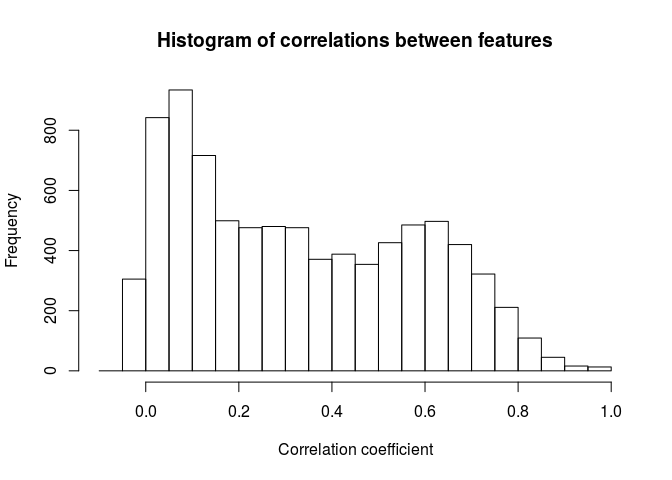

A heatmap is shown below

``` r
qplot(x=Var1, y=Var2, data=feature_cors, fill=value, geom="tile") +
  scale_fill_gradient2(limits=c(min(feature_cors$value), 1)) +
theme(axis.text.x = element_blank(), axis.text.y = element_blank(), 
      axis.ticks.x = element_blank(), axis.ticks.y = element_blank(), 
      axis.title.x = element_blank(), axis.title.y = element_blank())
```

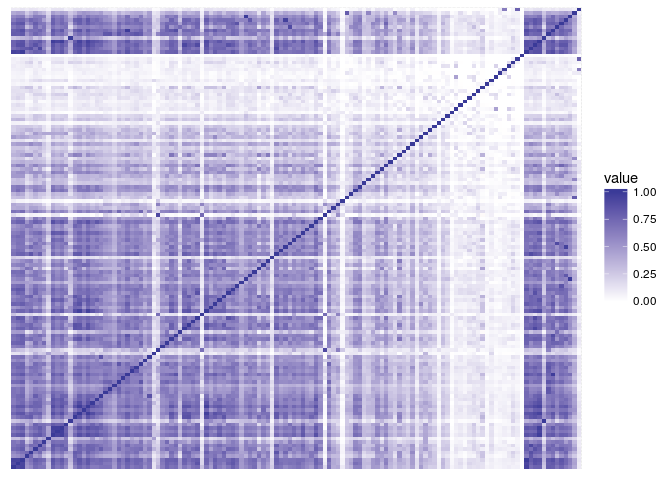

The top 25 correlating features are shown below.

| A                               | B                                    | correlation |
|:--------------------------------|:-------------------------------------|------------:|
| Gene.or.Genome                  | Genes…Molecular.Sequences            |   0.9999951 |
| Devices                         | Medical.Device                       |   0.9950808 |
| Disorders                       | Finding                              |   0.9876788 |
| Procedures                      | Therapeutic.or.Preventive.Procedure  |   0.9855405 |
| Amino.Acid..Peptide..or.Protein | Biologically.Active.Substance        |   0.9798380 |
| Chemicals…Drugs                 | Chemical.Viewed.Structurally         |   0.9743913 |
| Chemicals…Drugs                 | Pharmacologic.Substance              |   0.9730665 |
| Organic.Chemical                | Pharmacologic.Substance              |   0.9654066 |
| Chemical.Viewed.Structurally    | Pharmacologic.Substance              |   0.9645192 |
| Amino.Acid..Peptide..or.Protein | Enzyme                               |   0.9619148 |
| Natural.Phenomenon.or.Process   | Phenomena                            |   0.9582267 |
| Biologically.Active.Substance   | Enzyme                               |   0.9574220 |
| Disease.or.Syndrome             | Disorders                            |   0.9508563 |
| Chemical.Viewed.Structurally    | Organic.Chemical                     |   0.9470640 |
| Amino.Acid..Peptide..or.Protein | Chemicals…Drugs                      |   0.9465890 |
| Biologically.Active.Substance   | Chemicals…Drugs                      |   0.9465754 |
| Disease.or.Syndrome             | Finding                              |   0.9439068 |
| Finding                         | Pathologic.Function                  |   0.9379136 |
| Chemicals…Drugs                 | Organic.Chemical                     |   0.9294186 |
| Disorders                       | Pathologic.Function                  |   0.9290171 |
| Molecular.Function              | Physiology                           |   0.9225581 |
| Anatomy                         | Body.Part..Organ..or.Organ.Component |   0.9155275 |
| Bacterium                       | Species                              |   0.9132825 |
| Biologically.Active.Substance   | Physiology                           |   0.9130890 |
| Disease.or.Syndrome             | Pathologic.Function                  |   0.9083414 |

### <span class="header-section-number">2.3.3</span> Distribution of “direct” relationship between positive and negative cases

One would assume that the availability of a direct relationship between
the drug and the disease would indicate a positive case, and its absense
a negative case. To test this assumption, we tabulate this data.

| Goldstandard | Direct | Frequency |
|:-------------|:-------|----------:|
| VALID        | FALSE  |      3034 |
| INVALID      | FALSE  |      1115 |
| VALID        | TRUE   |      3010 |
| INVALID      | TRUE   |       906 |

As can be seen, a direct relationship is not exclusive to the positive
cases.

## <span class="header-section-number">2.4</span> Machine learning analysis

We use machine learning to classify the cases as “VALID” or “INVALID”
drug-disease combinations. We also perform machine learning analyses of
variations of the dataset to ensure the performance is not dependent on
the distribution of the positive or negative cases of the data, or the
specific disease class.

### <span class="header-section-number">2.4.1</span> Repeated cross validation

We perform a 10-fold cross validation, which we repeat 10 times.

``` r
# Perform the repeated cross validation analysis
model = train(y = goldstandard, x = feature_set, method = "rf",
              trControl=trainControl(method="repeatedcv", number=10, repeats = 10,
                                     classProbs = TRUE, savePredictions = TRUE, 
                                     summaryFunction = twoClassSummary),
              prox=FALSE, allowParallel=TRUE, metric = "ROC")

performance_metrics = model$results[model$results$mtry == model$bestTune$mtry, ]
variable_importances = varImp(model, scale = T)$importance
```

The performance of the classifier is shown below:

|      ROC |      Sens |      Spec |    ROCSD |
|---------:|----------:|----------:|---------:|
| 0.922002 | 0.9614822 | 0.6785256 | 0.011657 |

A histogram of the scores of its predictions is shown in the figure
below:

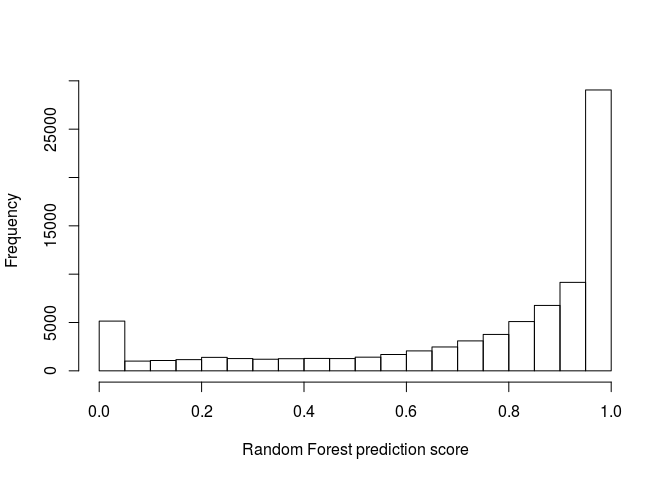

The ROC plot of the model is shown below, along with the curves of the
individual repeats in grey (may not be visible in the plot).
Furthermore, we calculate the mean F1 and the mean area under the
precision/recall curve (AUPR) of the individual classifications. We find
that the mean F1 score is 0.929, with an SD of 0.001. The mean AUPR is
0.964, with an SD of 0.001.



The 20 most important variables are shown in the table below.

| Variable                              |      Score |
|:--------------------------------------|-----------:|
| Cell                                  | 100.000000 |
| Disease or Syndrome                   |  73.443954 |
| Neoplastic Process                    |  64.640193 |
| Chemicals Drugs                       |  26.551719 |
| Chemical Viewed Structurally          |  25.625877 |
| Living Beings                         |  22.767386 |
| Disorders                             |  21.370327 |
| Sign or Symptom                       |  16.825913 |
| Nucleic Acid Nucleoside or Nucleotide |  15.884088 |
| Anatomy                               |  15.586965 |
| Finding                               |  13.512494 |
| Gene or Genome                        |  13.454059 |
| Genes Molecular Sequences             |  12.623107 |
| Mammal                                |  11.565656 |
| Pharmacologic Substance               |  11.505025 |
| Therapeutic or Preventive Procedure   |  11.061292 |
| Organic Chemical                      |  10.759868 |
| Cell Function                         |   9.516966 |
| Population Group                      |   9.331665 |
| Procedures                            |   9.209800 |

We also plot a figure of the feature importances.

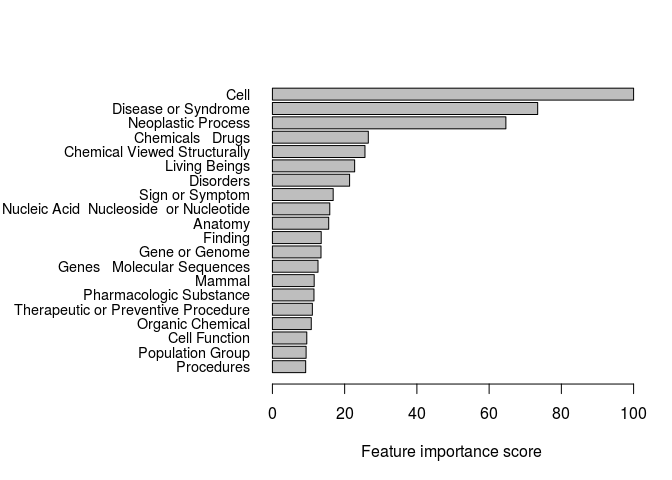

### <span class="header-section-number">2.4.2</span> Classify cancers and non-cancers separately from each other

The RepoDB set consists of cancers and non-cancers, as specified by
Brown and Patel. If we look at how these are disributed accross the
positive and the negative cases, we find that this distribution is
skewed.

``` r
# Read in the file with the cancers vs. non-cancer diseases
repoDB = read.csv("RepoDB.csv", stringsAsFactors = F)
non_cancers = read.csv2("Disease or Syndrome list.csv", stringsAsFactors = F, header = F)
all$diseaseClass = ifelse(all$disease_id %in% repoDB$ind_id[repoDB$ind_name %in% non_cancers$V1], "Non-cancer", "Cancer")
```

First we count the unique number of cancers/non-cancers in the positive
and negative set.

| Set      | Non_cancer | Cancer |
|:---------|-----------:|-------:|
| Total    |        933 |    751 |
| Positive |        787 |    324 |
| Negative |        226 |    493 |

We examine whether within the cross validation, cancers are classified
differently than non-cancers.

We find that the non-cancers achieve a mean AUC of 0.842, with an SD of
0.002, and the cancers achieve a mean AUC of 0.916, with an SD of 0.001.

Next, we investigate whether the difference in classification
performance is caused by their different ratios of positive cases and
negative cases. We first show the difference in class balance between
the cancers and the non-cancers. These are the non-unique numbers.

| Class   | Cancer | Non-cancer |
|:--------|-------:|-----------:|
| INVALID |   1590 |        431 |
| VALID   |   1519 |       4525 |

As can be seen, the cancer set is roughly balanced, while the non-cancer
set has a positive/negative ratio of roughly 10:1. We therefore sample
both sets to fit the other’s ratio. To obtain insight into the
distribution, we repeat the sampling.

``` r
# Split up the dataset according to its disease category

# This function samples the dataset.
SampleSet = function(df, n, n2, pos_class = "VALID"){
  sampleSet = rbind(df[sample(row.names(df[df$goldstandard == pos_class, ]), n),], 
                   df[sample(row.names(df[!df$goldstandard == pos_class, ]), n2),])
  return(sampleSet)}

## Cancers
features_cancers = all[all$diseaseClass == "Cancer", ]
cancers = data.frame()

for(i in 1:10){
  # See table above for class distribution of non-cancers, which is rougly 10:1
  features_cancers_rebalanced = SampleSet(features_cancers, 1500, 150)
  goldstandard_cancers_rebalanced = features_cancers_rebalanced$goldstandard
  features_cancers_rebalanced = features_cancers_rebalanced[,!colnames(features_cancers_rebalanced) %in% exclusion_columns]
  
  # Sampled classification
  cancer_model_rebalanced = train(y = goldstandard_cancers_rebalanced, x = features_cancers_rebalanced, method = "rf",
                trControl=trainControl(method="cv", number=10, 
                                       classProbs = TRUE, savePredictions = TRUE, 
                                       summaryFunction = twoClassSummary),
                prox=FALSE, allowParallel=TRUE, metric = "ROC")
  cancers = rbind(cancers, cancer_model_rebalanced$results[cancer_model_rebalanced$results$mtry == cancer_model_rebalanced$bestTune$mtry, c("ROC", "ROCSD",  "Sens", "Spec")])
}
cancers = rbind(cancers, Mean = apply(cancers, 2, mean), SD = apply(cancers, 2, sd))
```

Below are the unbalanced results, i.e. when the ratio is the same as
those of the non-cancers.

|      |       ROC |     ROCSD |      Sens |      Spec |
|------|----------:|----------:|----------:|----------:|
| 2    | 0.8764889 | 0.0337794 | 0.9946667 | 0.3666667 |
| 21   | 0.8815778 | 0.0357584 | 0.9946667 | 0.3133333 |
| 22   | 0.8637556 | 0.0528865 | 0.9933333 | 0.3466667 |
| 23   | 0.9014000 | 0.0409376 | 0.9920000 | 0.3066667 |
| 24   | 0.8994667 | 0.0408794 | 0.9946667 | 0.3600000 |
| 25   | 0.8688667 | 0.0678072 | 0.9953333 | 0.3600000 |
| 26   | 0.8526889 | 0.0689064 | 0.9926667 | 0.3400000 |
| 27   | 0.9214000 | 0.0196021 | 0.9946667 | 0.3733333 |
| 28   | 0.8448222 | 0.0366495 | 0.9933333 | 0.3266667 |
| 29   | 0.8683111 | 0.0443664 | 0.9920000 | 0.3133333 |
| Mean | 0.8778778 | 0.0441573 | 0.9937333 | 0.3406667 |
| SD   | 0.0236373 | 0.0152998 | 0.0012252 | 0.0244343 |

``` r
## Non-cancers
features_non_cancers = all[all$diseaseClass == "Non-cancer", ]

non_cancers = data.frame()

for(i in 1:10){
  # See table above for class distribution cancers, which is roughly 1:1
  min_class = length(which(features_non_cancers$goldstandard == "INVALID"))
  features_non_cancers_balanced = SampleSet(features_non_cancers, 431, 431)
  goldstandard_non_cancers_balanced = features_non_cancers_balanced$goldstandard
  
  features_non_cancers_balanced = features_non_cancers_balanced[,!colnames(features_non_cancers_balanced) %in% exclusion_columns]
  
  # Sampled classification
  non_cancer_model_balanced = train(y = goldstandard_non_cancers_balanced, x = features_non_cancers_balanced, method = "rf",
                trControl=trainControl(method="cv", number=10, 
                                       classProbs = TRUE, savePredictions = TRUE, 
                                       summaryFunction = twoClassSummary),
                prox=FALSE, allowParallel=TRUE, metric = "ROC")
  non_cancers = rbind(non_cancers, non_cancer_model_balanced$results[non_cancer_model_balanced$results$mtry == non_cancer_model_balanced$bestTune$mtry, c("ROC", "ROCSD",  "Sens", "Spec")])
}
non_cancers = rbind(non_cancers, Mean = apply(non_cancers, 2, mean), SD = apply(non_cancers, 2, sd))
```

Similarly, we performed the same classifications for the non-cancers.
Below are the results for the balanced non-cancer set.

|      |       ROC |     ROCSD |      Sens |      Spec |
|------|----------:|----------:|----------:|----------:|
| 2    | 0.8300082 | 0.0464634 | 0.7308140 | 0.7702431 |
| 21   | 0.8275806 | 0.0444479 | 0.7402220 | 0.7658034 |
| 22   | 0.8359408 | 0.0504423 | 0.7195032 | 0.7958774 |
| 23   | 0.8280711 | 0.0514283 | 0.7356237 | 0.7866279 |
| 24   | 0.8399092 | 0.0235353 | 0.7192389 | 0.8072939 |
| 25   | 0.8382043 | 0.0650884 | 0.7283827 | 0.8099894 |
| 3    | 0.8395533 | 0.0284524 | 0.7169662 | 0.7980973 |
| 26   | 0.8429808 | 0.0351601 | 0.7330338 | 0.8026956 |
| 27   | 0.8459567 | 0.0361581 | 0.7586681 | 0.8167019 |
| 28   | 0.8329724 | 0.0450827 | 0.7401691 | 0.7864693 |
| Mean | 0.8361177 | 0.0426259 | 0.7322622 | 0.7939799 |
| SD   | 0.0063186 | 0.0121570 | 0.0125546 | 0.0167139 |

The performance of the cancers drops substantially, leading us to
conclude that the majority of the difference in classification
performance between the cancers and the non-cancers is caused by their
difference in class balance and sample size. Determining the cause for
the remainder of the difference requires further research, and is
considered to be beyond the scope of this project.

### <span class="header-section-number">2.4.3</span> Iteratively remove the most predictive features

To ensure that performance is not dependent on a small number of highly
predictive features, we iteratively remove the most important features,
and re-perform the cross-validation analyses. The results of these
experiments is shown below:

``` r
# Set the parameters
iterations = 3
importanceCutoff = 50
removalColumns = c()
removal_frame = data.frame()

# Start with the previously generated model
input_model = model

# Select the most predictive features
for(i in seq_along(1:iterations)){
  importances = varImp(input_model, scale = T)$importance
  removalColumns = append(removalColumns, row.names(importances)[which(importances$Overall >= importanceCutoff)])
  reduced_feature_set = feature_set[,!colnames(feature_set) %in% removalColumns]
  
  # Perform the classification again
  input_model = train(y = goldstandard, x = reduced_feature_set, method = "rf",
              trControl=trainControl(method="cv", number=10,
                                     classProbs = TRUE, savePredictions = TRUE, 
                                     summaryFunction = twoClassSummary),
              prox=FALSE, allowParallel=TRUE, metric = "ROC")
  removal_frame = rbind(removal_frame, cbind(data.frame(iteration = i, nFeatures_removed = length(removalColumns), input_model$results[input_model$results$mtry == input_model$bestTune$mtry, c("ROC", "ROCSD", "Sens", "Spec")])))
}
```

As can be seen, the 15 most important features can be removed, while
still maintaining a high performance.

| iteration | nFeatures_removed |       ROC |     ROCSD |      Sens |      Spec |
|----------:|------------------:|----------:|----------:|----------:|----------:|
|         1 |                 3 | 0.9143176 | 0.0103285 | 0.9631033 | 0.6452300 |
|         2 |                 5 | 0.8936512 | 0.0130485 | 0.9535047 | 0.6160196 |
|         3 |                15 | 0.8793355 | 0.0146735 | 0.9376252 | 0.6081378 |

### <span class="header-section-number">2.4.4</span> Remove the highly correlating features.

Finally, we remove the highly correlating features at various cutoffs,
to quanity their influence.

``` r
cutoff_outcomes = data.frame(cutoffValue = seq(0.9, 0.3, -0.1), RemovedFeatureCount = NA)
cutoff_outcomes2 = data.frame()

for(i in 1:nrow(cutoff_outcomes)){
  removalColumns = c()
  overcorrelated = feature_combos[feature_combos$correlation >= cutoff_outcomes$cutoffValue[i],]
  for(j in 1:nrow(overcorrelated)){
    if(overcorrelated$A[j] %in% removalColumns | overcorrelated$B[j] %in% removalColumns){
      next
    } else {
      removalColumns = append(removalColumns, overcorrelated$A[j])
    }
  }
  cutoff_outcomes$RemovedFeatureCount[i] = length(unique(removalColumns))
  
  reduced_features = feature_set[,!colnames(feature_set) %in% removalColumns]
  model = train(y = goldstandard, x = reduced_features, method = "rf",
              trControl=trainControl(method="cv", number=10,
                                     classProbs = TRUE, savePredictions = TRUE, 
                                     summaryFunction = twoClassSummary),
              prox=FALSE, allowParallel=TRUE, metric = "ROC")
  cutoff_outcomes2 = rbind(cutoff_outcomes2, model$results[model$results$mtry == model$bestTune$mtry, ])
}
cutoff_outcomes = cbind(cutoff_outcomes, cutoff_outcomes2[,c("ROC", "ROCSD", "Sens", "Spec")])
```

| cutoffValue | RemovedFeatureCount |       ROC |     ROCSD |      Sens |      Spec |
|------------:|--------------------:|----------:|----------:|----------:|----------:|
|         0.9 |                  17 | 0.9186974 | 0.0135884 | 0.9583055 | 0.6704507 |
|         0.8 |                  38 | 0.9084146 | 0.0126481 | 0.9597956 | 0.6665098 |
|         0.7 |                  56 | 0.7889999 | 0.0315681 | 0.9367974 | 0.5324172 |
|         0.6 |                  73 | 0.7846370 | 0.0269281 | 0.9262107 | 0.5299444 |
|         0.5 |                  82 | 0.7052505 | 0.0245982 | 0.9207433 | 0.4285251 |
|         0.4 |                  89 | 0.6027743 | 0.0211634 | 0.9363034 | 0.2513705 |
|         0.3 |                  96 | 0.5813686 | 0.0346742 | 0.9449105 | 0.1786324 |

### <span class="header-section-number">2.4.5</span> Classify with different positive/negative class ratios

To ensure our classifier works when the ratios between the positive and
the negative cases change, we sample from both classes and repeat the
machine learning analysis.

``` r
# The vector below shows the ratios between the positive and negative cases we shall test
out_ratios = data.frame(ratio = round(c(5/1, 4/1, 3/1, 3/2, 2/1, 1/1, 1/2, 2/3, 1/3, 1/4, 1/5), 2),
                        ROC = NA, ROCSD = NA, Sens = NA, Spec = NA)

# Set the minority class
minorityClass = "INVALID"
minority_size = length(which(goldstandard == minorityClass))
majority_size = length(which(goldstandard != minorityClass))

for(r in 1:nrow(out_ratios)) {
  if(minority_size * out_ratios$ratio[r] > majority_size){
    min_input = ceiling(majority_size / out_ratios$ratio[r])
    max_input = majority_size
  } else {
    min_input = minority_size
    max_input = floor(minority_size * out_ratios$ratio[r])
  }
  sampled_input = SampleSet(all, max_input, min_input)
  sampled_goldstandard = sampled_input$goldstandard
  sampled_input = sampled_input[,!colnames(sampled_input) %in% exclusion_columns]
  
  # Create the model based on the input
  model = train(y = sampled_goldstandard, x = sampled_input, method = "rf",
              trControl=trainControl(method="cv", number=10, 
                                     classProbs = TRUE, savePredictions = TRUE, 
                                     summaryFunction = twoClassSummary),
              prox=FALSE, allowParallel=TRUE, metric = "ROC")
  out_ratios[r,c("ROC", "ROCSD", "Sens", "Spec")] = model$results[model$results$mtry == model$bestTune$mtry, c("ROC", "ROCSD",  "Sens", "Spec")]
}
```

As can be seen, performance remains roughly constant across the various
ratios of positive and negative cases.

| ratio |       ROC |     ROCSD |      Sens |      Spec |
|------:|----------:|----------:|----------:|----------:|
|  5.00 | 0.9221141 | 0.0180800 | 0.9770048 | 0.6145592 |
|  4.00 | 0.9187111 | 0.0087397 | 0.9700547 | 0.6320277 |
|  3.00 | 0.9215803 | 0.0163976 | 0.9612832 | 0.6744939 |
|  1.50 | 0.9211431 | 0.0113052 | 0.9132328 | 0.7560772 |
|  2.00 | 0.9216021 | 0.0153863 | 0.9371654 | 0.7194581 |
|  1.00 | 0.9211573 | 0.0162919 | 0.8545115 | 0.8248330 |
|  0.50 | 0.9107648 | 0.0137910 | 0.7168317 | 0.9139126 |
|  0.67 | 0.9217969 | 0.0098302 | 0.7954630 | 0.8777911 |
|  0.33 | 0.9154994 | 0.0145166 | 0.6308232 | 0.9460664 |
|  0.25 | 0.8965189 | 0.0177217 | 0.5348627 | 0.9589328 |
|  0.20 | 0.9079519 | 0.0240182 | 0.5270732 | 0.9658660 |

## <span class="header-section-number">2.5</span> Predict the potential new drugs for PKD

Tolvaptan was already mentioned as a treatment for ADPKD in RepoDB, so
for that drug we check its cross-validation performance. We find its
mean prediction score is 0.776, with an sd of 0.031.

We create a model based on the complete data to predict which drugs are
likely to be efficacious to treat Polycystic Kindey Syndrome (PKD).

``` r
# Read in the features for the PKD drugs
pkd = read.csv2("PKD features.csv", stringsAsFactors = F)
# Check whether drug-PKD combinations are not already a part of the training set
nrow(all[all$drug_id %in% pkd$drug_id & all$disease_id %in% pkd$disease_id, ]) > 0
```

    ## [1] FALSE

As can be seen, the other PKD-drug combinations were not available in
the training set.

``` r
# Create a model based on the data 
model = train(y = goldstandard, x = feature_set, method = "rf",
              trControl=trainControl(method="none", classProbs = TRUE, savePredictions = TRUE, 
                                     summaryFunction = twoClassSummary),
              prox=FALSE, allowParallel=TRUE, metric = "ROC")

# Create the feature set for PKD
pkd = pkd[, !colnames(pkd) %in% exclusion_columns]

# Predict the drug-PKD combinations
pkd_predictions = predict(model, pkd, type = "prob")
```

| Drug                                             | Prediction |
|:-------------------------------------------------|-----------:|
| mozavaptan                                       |          1 |
| satavaptan                                       |      0.930 |
| n-hydroxy-n’-(4-butyl-2-methylphenyl)formamidine |      0.926 |
| pasireotide                                      |      0.906 |
| bosutinib                                        |      0.886 |
| ex 527                                           |      0.738 |
| pioglitazone                                     |      0.682 |
| octreotide                                       |      0.672 |
| roscovitine                                      |      0.658 |
| pyrimethamine                                    |      0.650 |
| tram 34                                          |      0.650 |
| etanercept                                       |      0.642 |
| triptolide                                       |      0.602 |
| rosiglitazone                                    |      0.594 |
| u 0126                                           |      0.552 |
| vitamin k 3                                      |      0.522 |
| curcumin                                         |      0.460 |
| metformin                                        |      0.424 |
| everolimus                                       |      0.350 |
| sirolimus                                        |      0.270 |
| sorafenib                                        |      0.190 |

For one potential drug, teriflunomide, no indirect relationships to PKD
were available. Because of that, it was excluded from the predictions.

## <span class="header-section-number">2.6</span> Control experiments

This section describes the control experiments we performed to ensure
our method and results continue to be valid under different conditions.

### <span class="header-section-number">2.6.1</span> Label scrambling

To ensure that there truly is a pattern in the data, and that it is not
possible to train a classifier for anything on it, we scramble the
labels and try to classify again.

``` r
# For the sake of simplicity, we sample to a balanced set
sampled_input = SampleSet(all, minority_size, minority_size)

# Create a random goldstandard
scrambled_goldstandard = factor(sample(unique(goldstandard), size = 2 * minority_size, replace = T), levels = c("VALID", "INVALID"))
sampled_input = sampled_input[,!colnames(sampled_input) %in% exclusion_columns]

# Perform the machine learning analysis
model = train(y = scrambled_goldstandard, x = sampled_input, method = "rf",
              trControl=trainControl(method="cv", number=10,
                                     classProbs = TRUE, savePredictions = TRUE, 
                                     summaryFunction = twoClassSummary),
              prox=FALSE, allowParallel=TRUE, metric = "ROC")
```

|       ROC |     ROCSD |      Sens |      Spec |
|----------:|----------:|----------:|----------:|
| 0.4955835 | 0.0303836 | 0.5053987 | 0.5019509 |

### <span class="header-section-number">2.6.2</span> Logistic regression

We also examine the added value of using machine learning algorithms by
comparing the performance of the random forests algorithm with the
performance of a logistic regression.

``` r
# Perform the repeated cross validation analysis
model = train(y = goldstandard, x = feature_set, method = "glm",
              trControl=trainControl(method="cv", number=10,
                                     classProbs = TRUE, savePredictions = TRUE, 
                                     summaryFunction = twoClassSummary), metric = "ROC")
```

|       ROC |     ROCSD |      Sens |      Spec |
|----------:|----------:|----------:|----------:|
| 0.8150518 | 0.0173333 | 0.9485452 | 0.3409208 |

As can be seen, performance is considerably lower than that achieved by
the random forest algorithm.

### <span class="header-section-number">2.6.3</span> Neural network

We also examine whether random forests are truly the optimal choice by
also training a neural network, and comparing performance.

``` r
# Perform the repeated cross validation analysis
model = train(y = goldstandard, x = feature_set, method = "nnet",
              trControl=trainControl(method="cv", number=10,
                                     classProbs = TRUE, savePredictions = TRUE, 
                                     summaryFunction = twoClassSummary),
              prox=FALSE, allowParallel=TRUE, metric = "ROC")
```

|      ROC |     ROCSD |      Sens |      Spec |
|---------:|----------:|----------:|----------:|
| 0.889039 | 0.0157235 | 0.9402758 | 0.6372872 |

While performance is higher than the logistic regression, it is still
lower than the random forest algorithm.

### <span class="header-section-number">2.6.4</span> Carefully separating the drugs/diseases from the positive cases and negative cases.

Here, I try to perform some of the experiments and checks described by
Guney in his publication [REPRODUCIBLE DRUG REPURPOSING: WHEN SIMILARITY
DOES NOT SUFFICE](https://www.ncbi.nlm.nih.gov/pubmed/27896969).

While it is not completely clear whether the objections to similarity
based methods are applicable to our research, the drastic decrease in
performance he describes necessitate these additional experiments in my
view. With similarity based methods, the repurposing of drugs is
determined by the number of potential adverse effects they have in
common, their chemical similarity, and the similarity in their drug
targets. The feature sets of similarity based methods therefore look
somewhat different. While we represent a category of concepts,
e.g. proteins, simply as a count, similarity based feature sets create a
column for every protein associated with a drug, and use binary yes/no
information for every drug to indicate whether it is associated with
that specific protein.

The core of Guney’s argument why similarity based methods do not work is
as follows: Many similarity based methods allow the same drug to be part
of both the training and the test set. However, this scenario is not
realistic when you consider new drugs, of which little is known. He
therefore tests this scenario by completely removing a sample of the
drugs from the training set, and attempts to classify them. For
similarity based methods, he reports decreases from \~85% ROC AUC to
\~60% ROC AUC for these methods. Because his similarity based method
uses such different feature sets, I will implement his different
validation method myself here.

``` r
# Create the folds manually, we perform 10 fold cross validation again
nFolds = 10
drugs = unique(all$drug_id)
folds = createFolds(drugs, k = nFolds)

# Create a data frame in which the outcomes will be stored
outcomes = data.frame(fold = seq(1, nFolds), ROC = NA, Sensitivity = NA, Specificity = NA, ratio_training = NA, ratio_test = NA)

# Manually perform the cross validation
for(i in 1:nFolds){
  # Create carefully separated training and test sets
  test_set = all[which(all$drug_id %in% drugs[folds[i][[1]]]), ]
  training_set = all[which(!all$drug_id %in% drugs[folds[i][[1]]]), ]
  training_set_gs = factor(training_set$goldstandard, levels = c("VALID", "INVALID"))
  training_set = training_set[,!colnames(training_set) %in% exclusion_columns]
  
  # Describe the dimensions of the sets
  training_distribution = table(training_set_gs)
  outcomes$ratio_training[i] = training_distribution["VALID"] / training_distribution["INVALID"]
  test_distribution = table(test_set$goldstandard)
  outcomes$ratio_test[i] = test_distribution["VALID"] / test_distribution["INVALID"]
  
  # Perform the machine learning analysis
  cv_model =  train(x = training_set, y = training_set_gs, method = "rf", 
              trControl=trainControl(method="none", classProbs = TRUE, 
              savePredictions = TRUE, summaryFunction = twoClassSummary),
              prox=TRUE, allowParallel=TRUE, metric = "ROC")
  
  # Predict the test set
  predictions = predict(cv_model, test_set, type = "prob")
  predictions$binary = ifelse(predictions$VALID > 0.5, "VALID", "INVALID")
  
  # Evaluate the performance of the test set
  outcomes$ROC[i] = as.numeric(roc(test_set$goldstandard, predictions$VALID)$auc)
  confMat = confusionMatrix(predictions$binary, test_set$goldstandard, positive = "VALID")
  outcomes[i, c("Sensitivity", "Specificity")] = confMat$byClass[c("Sensitivity", "Specificity")]
}
  outcomes = rbind(outcomes, c("Mean", apply(outcomes[,c("ROC", "Sensitivity", "Specificity", "ratio_training", "ratio_test")], 2, mean)))  
```

| fold |   ROC | Sensitivity | Specificity | ratio_training | ratio_test |
|:-----|------:|------------:|------------:|---------------:|-----------:|
| 1    | 0.914 |       0.964 |       0.623 |          2.902 |      4.130 |
| 2    | 0.905 |       0.967 |       0.565 |          2.930 |      3.911 |
| 3    | 0.882 |       0.937 |       0.528 |          2.923 |      4.217 |
| 4    | 0.958 |       0.965 |       0.786 |          3.152 |      2.079 |
| 5    | 0.931 |       0.961 |       0.704 |          3.052 |      2.684 |
| 6    | 0.884 |       0.985 |       0.503 |          2.909 |      3.851 |
| 7    | 0.919 |       0.909 |       0.710 |          3.150 |      1.982 |
| 8    | 0.897 |       0.958 |       0.638 |          2.955 |      3.478 |
| 9    | 0.895 |       0.968 |       0.582 |          2.974 |      3.123 |
| 10   | 0.863 |       0.953 |       0.609 |          2.990 |      2.995 |
| Mean | 0.905 |       0.957 |       0.625 |          2.994 |      3.245 |

As can be seen, there is only a minor drop in performance when carefully
separating the drugs in the training and test sets.

### <span class="header-section-number">2.6.5</span> Varying the number of cross-validation folds

Guney also described that the number of folds of the cross validation
impacts the performance. I will therefore also repeat his experiments by
varying the number of folds.

``` r
alternativeFolds = c(2,5,20)
vary_folds = data.frame()

for(i in 1:length(alternativeFolds)){
  # Perform the repeated cross validation analysis
  model = train(y = goldstandard, x = feature_set, method = "rf",
                trControl=trainControl(method="cv", number=alternativeFolds[i],
                                       classProbs = TRUE, savePredictions = TRUE, 
                                       summaryFunction = twoClassSummary),
                prox=FALSE, allowParallel=TRUE, metric = "ROC")
  
  vary_folds = rbind(vary_folds, model$results[model$results$mtry == model$bestTune$mtry, ])
}
vary_folds = cbind(foldsCount = alternativeFolds, vary_folds)
```

| foldsCount |       ROC |     ROCSD |      Sens |      Spec |
|-----------:|----------:|----------:|----------:|----------:|
|          2 | 0.9142620 | 0.0007866 | 0.9566512 | 0.6571060 |
|          5 | 0.9224223 | 0.0032506 | 0.9601258 | 0.6689818 |
|         20 | 0.9226000 | 0.0198941 | 0.9609583 | 0.6808484 |

Varying the cross-validation folds does not appear to influence
performance.

# <span class="header-section-number">3</span> Conclusions

Classifying drug-disease combinations based on the semantic types and
semantic groups of their intermediate concepts appears to perform well.
Perfromance remains high, even when removing the most predictive
features, varying the ratio between the positive cases and the negative
cases, varying the number of cross-validation folds, or carefully
separating the drugs in the training and the test set. When separating
the set into cancers and non-cancers, performance also remains high,
indicating that we are not classifying cancer vs. non-cancer, which is a
real risk, given theirs skewed distribution in the positive and negative
set. The majority of the difference between the cancers and the
non-cancers can be attributed to their difference in sample size and
class balance. A minor difference remains, which we have not further
investigated.

Given the difference in performance between random forests and the
logistic regression, a machine learning approach appears to be
justified. Random forests also perform superior to neural networks,
although the difference is not very large.

We trained a classifier on the complete set, and whether a selection of
drugs is likely to work against PKD. Validating these predictions will
have to be performed in a wet-lab or during clinical trials.

# <span class="header-section-number">4</span> Used R-version and packages

I used the following software for this research:

    ## R version 3.2.3 (2015-12-10)
    ## Platform: x86_64-pc-linux-gnu (64-bit)
    ## Running under: Ubuntu 16.04.2 LTS
    ## 
    ## locale:
    ##  [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
    ##  [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
    ##  [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
    ##  [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
    ##  [9] LC_ADDRESS=C               LC_TELEPHONE=C            
    ## [11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       
    ## 
    ## attached base packages:
    ## [1] parallel  stats     graphics  grDevices utils     datasets  methods  
    ## [8] base     
    ## 
    ## other attached packages:
    ##  [1] nnet_7.3-12         doMC_1.3.4          iterators_1.0.8    
    ##  [4] foreach_1.4.3       reshape2_1.4.2      plyr_1.8.4         
    ##  [7] PRROC_1.3           pROC_1.9.1          randomForest_4.6-12
    ## [10] caret_6.0-76        ggplot2_2.2.1       lattice_0.20-33    
    ## [13] knitr_1.17          rmarkdown_1.8      
    ## 
    ## loaded via a namespace (and not attached):
    ##  [1] Rcpp_0.12.10       compiler_3.2.3     highr_0.6         
    ##  [4] nloptr_1.0.4       class_7.3-14       tools_3.2.3       
    ##  [7] digest_0.6.12      lme4_1.1-13        evaluate_0.10.1   
    ## [10] tibble_1.3.4       gtable_0.2.0       nlme_3.1-124      
    ## [13] mgcv_1.8-11        rlang_0.1.4        Matrix_1.2-3      
    ## [16] yaml_2.1.14        SparseM_1.76       e1071_1.6-8       
    ## [19] stringr_1.2.0      MatrixModels_0.4-1 stats4_3.2.3      
    ## [22] rprojroot_1.2      grid_3.2.3         minqa_1.2.4       
    ## [25] car_2.1-4          magrittr_1.5       backports_1.1.1   
    ## [28] scales_0.4.1       codetools_0.2-14   ModelMetrics_1.1.0
    ## [31] htmltools_0.3.6    MASS_7.3-45        splines_3.2.3     
    ## [34] pbkrtest_0.4-7     colorspace_1.3-2   labeling_0.3      
    ## [37] quantreg_5.33      stringi_1.1.5      lazyeval_0.2.0    
    ## [40] munsell_0.4.3